# Error Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import re
import spacy
from IPython.display import display
import dateutil.parser as dateutil_parser
from string import punctuation

from config import Config
config = Config()
import utils
import eval.evaluate

%matplotlib inline

# Fix random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

nlp = spacy.load('en_core_web_sm')


In [2]:
# Ignores some problems on my system
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

## Dataset and predictions loading

In [3]:
TEST_DATASET_PATH = os.path.join(config.ROOT_PATH, 'data', 'dev_set.json')
VAL_DATASET_PATH = os.path.join(config.ROOT_PATH, 'data', 'validation_set.json')

PATH_TO_PREDICTIONS_TEST = os.path.join(config.ROOT_PATH, 'src', 'eval', 'normal_predictions_test_tpu.txt')
PATH_TO_PREDICTIONS_VAL = os.path.join(config.ROOT_PATH, 'src', 'eval', 'normal_predictions_val_tpu.txt')
PATH_TO_PREDICTIONS_BERT = os.path.join(config.ROOT_PATH, 'src', 'eval', 'BERT_predictions_test_tpu.txt')

In [4]:
test_data = utils.read_question_set(TEST_DATASET_PATH)
validation_data = utils.read_question_set(VAL_DATASET_PATH)

prediction_test = utils.read_question_set(PATH_TO_PREDICTIONS_TEST)
prediction_val = utils.read_question_set(PATH_TO_PREDICTIONS_VAL)
prediction_test_bert = utils.read_question_set(PATH_TO_PREDICTIONS_BERT)

## Question categorization

The dataset contains many different types of questions and answers: some are related to dates, some other to people, other to places and so on. We want to understand how well our model performs on these different types of questions.

First of all, we must partition the questions into their types. We do this by understanding whether the related answer is numerical (cardinal) or non-numerical. Non-numerical answers are further categorized using NER tags and the associated tag is linked to the question. 


In [5]:
def is_numeric(answer:str):
    # A pattern that recognizes only-numerical answers
    return re.match('[0-9–]+', answer)

def is_date(answer:str):
    # We use a function from the dateutil module to understand 
    # if a given answer contains a date.
    try:
        dateutil_parser.parse(answer, fuzzy=False)
        return True
    except:
        return False
        
def get_question_type(question, answer):
    # We parse the answer using spacy's library
    answer = answer.strip(punctuation)
    doc = nlp(answer)

    for token in doc: 
        # print(f"{token.text:{8}} {token.dep_+' =>':{10}}   {token.head.text:{9}} {token.ent_type_}")
        if token.ent_type_:
            # If we find an entity type in the answer, we return it
            return (token.ent_type_).lower()
    # Otherwise we check if the answer is a date...
    if is_date(answer):
        return 'date'
    # ... a number...
    if is_numeric(answer):
        return 'cardinal'
    # ... if the question contains "Who"...
    if question[:3].lower() == "who":
        return "person"
    # ... and if the answer is none of these categories and it's quite long, we consider it 
    # a "clause"...
    if len(doc) >4:
        return "clause"
    # ... or "other".
    return "other"

We apply this analysis on the *test dataset* using the predictions made by our *normal* model.

In [6]:
questions_type = []
# Iterate over all questions and answers of the test set
for article in (test_data['data']):
    for paragraph in article['paragraphs']:
        for question_and_answer in paragraph["qas"]:

            qid = question_and_answer['id']
            # Obtain the ground truth answers
            gold_answers = [a['text'] for a in question_and_answer['answers']]
            # Obtain our prediction
            a_pred = prediction_test[qid]
            # Compute the exact and F1 score between this and the best-scoring GT answer
            exact_score = max(eval.evaluate.compute_exact(a, a_pred) for a in gold_answers)
            f1_score = max(eval.evaluate.compute_f1(a, a_pred) for a in gold_answers)
            # We get the answer, the question, the question type and the context
            answer = random.sample(gold_answers, 1)[0]
            question = question_and_answer["question"]
            question_type = get_question_type(question, answer)
            context = paragraph["context"]
            # ... and we append all of these details into the list.
            questions_type.append([question_type, question, answer, a_pred, context, f1_score, exact_score])
            # errors.append([question_type, question, context, answer])

In [7]:
# We are then able to put all of these data into a dataframe
df = pd.DataFrame(questions_type, columns=["type", "question", "answer", "prediction", "context", "f1-score", "exact-score"])
df.head()

,type,question,answer,prediction,context,f1-score,exact-score
0,gpe,Which NFL team represented the AFC at Super Bo...,Denver Broncos,denver broncos,Super Bowl 50 was an American football game to...,1.000000,1
1,other,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,carolina panthers,Super Bowl 50 was an American football game to...,1.000000,1
2,gpe,Where did Super Bowl 50 take place?,"Santa Clara, California",levi's stadium,Super Bowl 50 was an American football game to...,1.000000,1
3,gpe,Which NFL team won Super Bowl 50?,Denver Broncos,denver broncos,Super Bowl 50 was an American football game to...,1.000000,1
4,other,What color was used to emphasize the 50th anni...,gold,"gold - themed initiatives, as well as temporar...",Super Bowl 50 was an American football game to...,0.105263,0


Here, we use spacy to explain each of the tags from our dataset:

In [8]:
for type in df["type"].unique():
    print("Tag: '{}' --> {}".format(type, spacy.explain(type.upper())))

Tag: 'gpe' --> Countries, cities, states
Tag: 'other' --> None
Tag: 'date' --> Absolute or relative dates or periods
Tag: 'org' --> Companies, agencies, institutions, etc.
Tag: 'cardinal' --> Numerals that do not fall under another type
Tag: 'person' --> People, including fictional
Tag: 'ordinal' --> "first", "second", etc.
Tag: 'fac' --> Buildings, airports, highways, bridges, etc.
Tag: 'norp' --> Nationalities or religious or political groups
Tag: 'time' --> Times smaller than a day
Tag: 'product' --> Objects, vehicles, foods, etc. (not services)
Tag: 'clause' --> None
Tag: 'event' --> Named hurricanes, battles, wars, sports events, etc.
Tag: 'money' --> Monetary values, including unit
Tag: 'percent' --> Percentage, including "%"
Tag: 'work_of_art' --> Titles of books, songs, etc.
Tag: 'loc' --> Non-GPE locations, mountain ranges, bodies of water
Tag: 'quantity' --> Measurements, as of weight or distance
Tag: 'language' --> Any named language
Tag: 'law' --> Named documents made into 

Let's see the score divided on each category.

In [9]:
scores_by_group = []

for key in df["type"].unique():
    f1_score = df[df["type"] == key]["f1-score"].sum()
    exact_score = df[df["type"] == key]["exact-score"].sum()
    total = len(df[df["type"] == key]["f1-score"])
    scores_by_group.append([key, f1_score/total, exact_score/total, total])

scores_by_group = pd.DataFrame(scores_by_group, columns=['CATEGORY', 'F1 SCORE', 'EXACT SCORE', 'NUMBER OF ELEMENTS'])
scores_by_group.sort_values(by='NUMBER OF ELEMENTS', ascending=False)

,CATEGORY,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS
1,other,0.710714,0.569850,3529
5,person,0.803258,0.728018,1342
3,org,0.756834,0.603758,1224
4,cardinal,0.515568,0.292851,1161
2,date,0.710365,0.503636,1100
11,clause,0.699988,0.474558,904
0,gpe,0.702117,0.532143,560
8,norp,0.708171,0.462094,277
16,loc,0.724291,0.590000,100
17,quantity,0.621850,0.295775,71


We check how many questions have a *completely wrong* answer, where we consider *completely wrong* as having an F1-Score less than 0.5 with the groundtruth.

In [10]:
F1_THRESHOLD=0.5

high_errors_df = df[df["f1-score"] < F1_THRESHOLD]
error_df = pd.DataFrame(high_errors_df.groupby("type", as_index=True).size().reset_index()).rename(columns={0: 'WRONG ANSWERS'})
errors_by_group = scores_by_group.merge(error_df, how='left', left_on='CATEGORY', right_on='type')[
        ['CATEGORY', 'F1 SCORE','EXACT SCORE', 'NUMBER OF ELEMENTS', 'WRONG ANSWERS']
    ]
errors_by_group['WRONG RATIO'] = errors_by_group['WRONG ANSWERS'] / errors_by_group['NUMBER OF ELEMENTS']
errors_by_group = errors_by_group.set_index('CATEGORY')
errors_by_group.sort_values('WRONG RATIO', ascending=False)

,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS,WRONG ANSWERS,WRONG RATIO
CATEGORY,,,,,
cardinal,0.515568,0.292851,1161,513,0.441860
money,0.518319,0.352941,51,22,0.431373
quantity,0.621850,0.295775,71,25,0.352113
law,0.700000,0.555556,9,3,0.333333
language,0.706349,0.500000,6,2,0.333333
ordinal,0.621288,0.375000,64,20,0.312500
time,0.685355,0.535714,28,8,0.285714
clause,0.699988,0.474558,904,247,0.273230
gpe,0.702117,0.532143,560,153,0.273214


From this analysis, we can see that our model gets really wrong a lot of questions about **numbers**, be it *cardinal numbers*, *money* or *quantities*. We can explain this by the fact that the tokenizer probably splits numbers that are not *common*, ignoring the fact that a number has value on its own, not just as a word.

Long answers which don't have a clear type are also a problem.

We show the kinds of mistakes our model makes using the following pie charts:

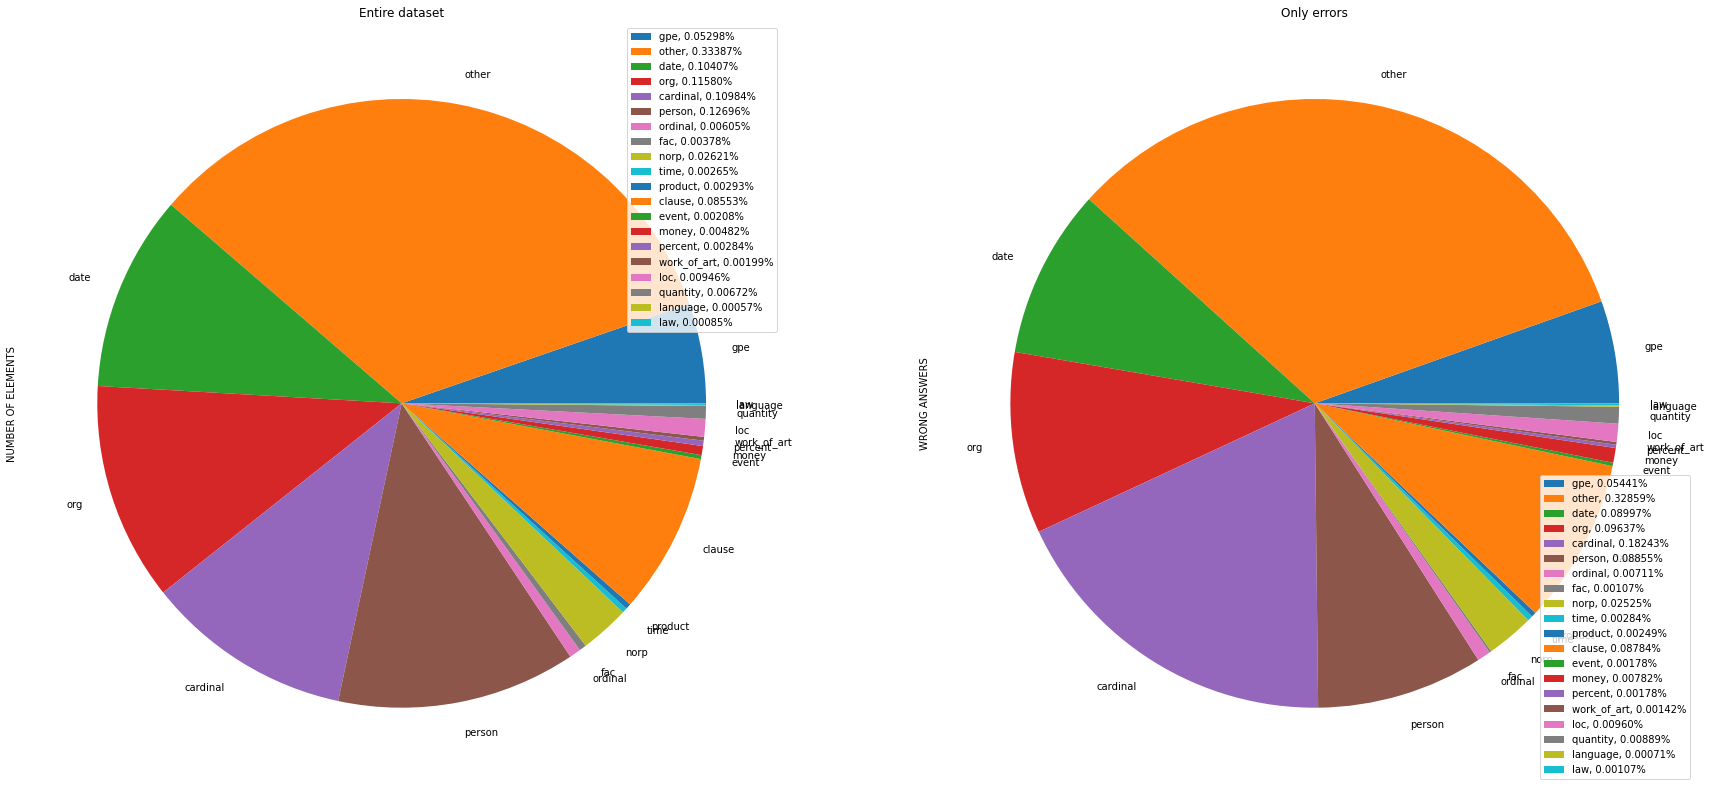

In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,30))
ax1.set_title("Entire dataset")
errors_by_group.plot.pie(y='NUMBER OF ELEMENTS', ax=ax1);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['NUMBER OF ELEMENTS']/errors_by_group['NUMBER OF ELEMENTS'].sum())]
ax1.legend(labels)

ax2.set_title("Only errors")
errors_by_group.plot.pie(y='WRONG ANSWERS', ax=ax2);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['WRONG ANSWERS']/errors_by_group['WRONG ANSWERS'].sum())]

ax2.legend(labels)

The quantities of errors overall match the data distribution.

Now, we analyze some of the errors for each question category:

In [12]:
errors_by_group_sorted = errors_by_group.sort_values(by='WRONG ANSWERS', ascending=False)

for key in list(errors_by_group_sorted.index):
    samples = high_errors_df[high_errors_df["type"]==key].drop(["f1-score", "exact-score"], axis=1).sample(2)
    print(key)
    display(samples)
    print()

other


,type,question,answer,prediction,context
3615,other,What form of oxygen do marine animals acquire ...,oxygen-18,oxygen - 18,Paleoclimatologists measure the ratio of oxyge...
9830,other,One country's authority over a number of other...,empires,geopolitics now focuses on states becoming maj...,"""The word ‘empire’ comes from the Latin word i..."



cardinal


,type,question,answer,prediction,context
8524,cardinal,How much of the population is Hindu?,"around 300,000","( around 300, 000",Sizeable minorities of other faiths do exist (...
3082,cardinal,How many Huguenots were killed during this purge?,"5,000 to 30,000","5, 000 to 30, 000",The Catholic Church in France and many of its ...



org


,type,question,answer,prediction,context
3545,org,What was Dalton's erroneous formula for water?,HO,"ho, giving the atomic mass of oxygen",John Dalton's original atomic hypothesis assum...
5963,org,"In 2013-14, NBC finished behind what network i...",CBS,"abc for eight years, finished the season in fi...",The 2013–14 season was a slight improvement fo...



date


,type,question,answer,prediction,context
6845,date,What year did the the case go before the supre...,1978,1978 supreme court case of fcc v. pacifica fou...,In cases where the criminalized behavior is pu...
5875,date,When did the Steven Spielberg movie Duel first...,1971,"september 1969, abc launched the movie of the ...","On the television side, in September 1969, ABC..."



person


,type,question,answer,prediction,context
608,person,What Universal trailer debuted during the Supe...,Jason Bourne,secret life of pets,"20th Century Fox, Lionsgate, Paramount Picture..."
6993,person,Who is required to verify and have existing ut...,contractors,"before the foundation can be dug, contractors","Before the foundation can be dug, contractors ..."



clause


,type,question,answer,prediction,context
3809,clause,"Why did GM, Ford and Chrysler introduced fuel-...",An increase in imported cars,an increase in imported cars into north americ...,An increase in imported cars into North Americ...
2150,clause,Since he didn't believe that salvation was acq...,gift of God's grace,as a free gift of god's grace through faith in...,Luther taught that salvation and subsequently ...



gpe


,type,question,answer,prediction,context
10483,gpe,Who figured out that his law of gravity had to...,Newton,henry cavendish able to make the first measure...,"In this equation, a dimensional constant is u..."
9847,gpe,Where was Friedrich Ratzel born?,Germany,friedrich ratzel of germany,The Royal Geographical Society of London and o...



norp


,type,question,answer,prediction,context
9634,norp,What term do Islamists think should be applied...,Muslims,islamism,"Islamists have asked the question, ""If Islam i..."
4741,norp,The west side of Fresno is the center of which...,African-American,african - american,"The ""West Side"" of Fresno, also often called ""..."



loc


,type,question,answer,prediction,context
4941,loc,Did the plague spread in Scandinavia or German...,Scandinavia,scandinavia and then germany,Gasquet (1908) claimed that the Latin name atr...
9995,loc,The Ottoman empire controlled territory on thr...,Europe,"the caucasus, north africa, and the horn of af...",The Ottoman Empire was an imperial state that ...



quantity


,type,question,answer,prediction,context
4773,quantity,What is the most rainfall recorded in a 24 hou...,3.55 inches,3. 55 inches,The official record high temperature for Fresn...
10235,quantity,What was extent of Celeron's expedition?,"about 3,000 miles","covered about 3, 000 miles ( 4, 800 km )",Céloron's expedition force consisted of about ...



money


,type,question,answer,prediction,context
7004,money,What is the average construction salary in the...,"£26,719","£42, 090",In 2010 a salary survey revealed the differenc...
2084,money,"What would a Preschool teacher make, salary-wise?","£20,980","£20, 980 annually","Salaries for Nursery, Primary and Secondary Sc..."



ordinal


,type,question,answer,prediction,context
4822,ordinal,How are packets normally forwarded,"asynchronously using first-in, first-out buffe...","using first - in, first - out buffering",Packet mode communication may be implemented w...
7830,ordinal,What logo is used for all merchandise that fea...,the logo used for the Third and Eighth Doctors,doctor who logo,The original logo used for the First Doctor (a...



time


,type,question,answer,prediction,context
7899,time,How long was the first audio of a Doctor Who s...,21-minute,21 - minute,The earliest Doctor Who-related audio release ...
7709,time,What is the most common length of Doctor Who e...,25-minute,25 - minute,826 Doctor Who instalments have been televised...



product


,type,question,answer,prediction,context
2431,product,What did this hymn presage?,explanation of the Apostles' Creed,"we all believe in one true god "" ) is a three ...","Luther's 1524 creedal hymn ""Wir glauben all an..."
4851,product,What supplanted Frame Relay and X.25,Internet Protocol (IP),x. 25 and frame relay provide connection - ori...,Both X.25 and Frame Relay provide connection-o...



percent


,type,question,answer,prediction,context
5005,percent,How many people died in the outbreak of 1471?,10–15% of the population,10 – 15 %,"In England, in the absence of census figures, ..."
941,percent,How much of Warsaw's population was Jewish?,some 30% of the city,several hundred thousand,After the German Invasion of Poland on 1 Septe...



event


,type,question,answer,prediction,context
616,event,What famous July Fourth holiday movie did Fox ...,Independence Day,deadpool,"20th Century Fox, Lionsgate, Paramount Picture..."
509,event,Which committee made an effort to invite compa...,the Super Bowl 50 Host Committee,the super bowl 50 host committee and the nfl h...,"For the first time, the Super Bowl 50 Host Com..."



work_of_art


,type,question,answer,prediction,context
10012,work_of_art,"Why was the student group called ""the Methodis...",being methodical and exceptionally detailed in...,started individual societies or classes for me...,The movement which would become The United Met...
576,work_of_art,What talk show followed immediately after Supe...,The Late Show with Stephen Colbert,late night talk shows as its lead - out progra...,"As opposed to broadcasts of primetime series, ..."



fac


,type,question,answer,prediction,context
855,fac,Where was the Summer Theatre located?,the Saxon Garden,ogrod saski,"Nearby, in Ogród Saski (the Saxon Garden), the..."
5439,fac,What was the building that formerly occupied t...,Brompton Park House,"brompton park house, which was extended, most ...",The Victorian parts of the building have a com...



law


,type,question,answer,prediction,context
4251,law,In which article does the Treaty of Lisbon pro...,Article 101(1),article 101 ( 1,"Today, the Treaty of Lisbon prohibits anti-com..."
4196,law,Which TEFU article states that no quantitative...,TFEU article 30,van gend en loos v nederlandse administratie d...,Although it is generally accepted that EU law ...



language


,type,question,answer,prediction,context
7053,language,"In private schools, what language are classes ...",English,english while it is the local language,"Legally, only non-profit trusts and societies ..."
7067,language,"In Nepalese private schools, what is the prima...",English,"english, but as a compulsory subject, nepali",The other category of schools are those run an...


We can see that:
- Some errors are related to having a few words more or less with respect to the ground truth answer
    - For instance, questions related to years often repeat a large part of the context, while the ground truth answer is simply the year.
- There are lots of errors that are due to our implementation of the answer extraction. 
    - Since the output indices are related to the sequence of tokens and not to the words in the paragraph, we actually decode the previously encoded tokens to extract the answer.
    - But this creates answers that are not necessarily part of the paragraph
    - Therefore, they may be valid answers (and in some of the presented cases, they are), but they are not *exactly* equal to the ground truth due to the addition of spaces or lowercase/uppercase letters
    - These are problems related to the tokenizer that have a huge impact in the performances
    - A solution to this problem might be changing the way we produce an answer by keeping track of the index transformation between tokens and character indices in the paragraph.
    - Or, in alternative, comparing our predicted answer to a decoded ground truth using the same tokenizer we used for the paragraph and the question.


## Dataset split difference

We have noticed a big difference in performances between validation and test sets, so we need to investigate this gap.